###  **Krok 1: Wyświetlenie obrazu oryginalnego (Shepp-Logan)**


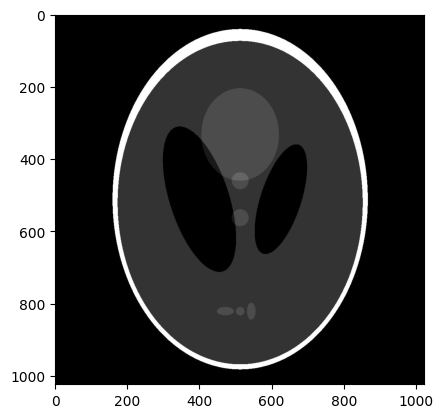

In [175]:
from skimage.io import imread
from skimage import color
import matplotlib.pyplot as plt
%matplotlib inline

obraz_sciezka = 'Shepp_logan.jpg'
kolorowy_obraz = imread(obraz_sciezka)
szaroskalowy_obraz = color.rgb2gray(kolorowy_obraz)
plt.imshow(szaroskalowy_obraz, cmap='gray')


### **Krok 2: Generowanie sinogramu (transformata Radona)**

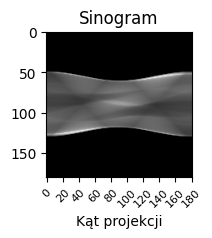

In [176]:
import math
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt

def algorytm_bresenhama(x_start, y_start, x_koniec, y_koniec):
    x = x_start
    y = y_start
    punkty = []
    if x_start < x_koniec:
        kier_x = 1
        dx = x_koniec - x_start
    else:
        kier_x = -1
        dx = x_start - x_koniec
    if y_start < y_koniec:
        kier_y = 1
        dy = y_koniec - y_start
    else:
        kier_y = -1
        dy = y_start - y_koniec

    punkty.append((x, y))

    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x_koniec:
            if d >= 0:
                x += kier_x
                y += kier_y
                d += ai
            else:
                d += bi
                x += kier_x
            punkty.append((x, y))
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y_koniec:
            if d >= 1:
                x += kier_x
                y += kier_y
                d += ai
            else:
                d += bi
                y += kier_y
            punkty.append((x, y))

    return punkty

# dx — odległość pozioma (różnica współrzędnych x)
# dy — odległość pionowa (różnica współrzędnych y)
# d  — aktualny błąd odchylenia od „idealnej” linii
# bi — wartość, o którą zwiększa się d, jeśli linia przesuwa się tylko wzdłuż osi x (bez zmiany y) (odwrotnie dla y)
# ai — wartość, o którą zwiększa się d, jeśli następuje krok zarówno po x, jak i po y (czyli po przekątnej) (odwrotnie dla x)



def transformata_radona(obraz, krok_a, zakres_pi, liczba_detektorow, krok_x):
    alfa = math.pi / 2
    liczba_katow = math.ceil(180 / krok_x) + 1
    detektory = [[0, 0] for _ in range(liczba_detektorow)]
    emitery = [[0, 0] for _ in range(liczba_detektorow)]
    dlugosc = len(obraz)
    szerokosc = len(obraz[0])
    r = math.floor(math.sqrt(dlugosc * dlugosc + szerokosc * szerokosc) / 2) # promień obrazu, używany do wyznaczenia rozmiaru nowego obrazu

    obraz1 = [[0 for _ in range(r * 2)] for __ in range(r * 2)] # dwa razy większy rozmiar niż oryginalny obraz
    l, w = obraz.shape
    y_offset = round((r * 2 - l) / 2) # przesunięcie w osi Y
    x_offset = round((r * 2 - w) / 2) # przesunięcie w osi X
    obraz1 = np.array(obraz1.copy())
    obraz1[y_offset:y_offset + l, x_offset:x_offset + w] = obraz

    sinogram = []

    # Obliczanie sinogramu – przejście przez wszystkie kąty
    for i in range(liczba_katow):
        strzał = [0 for _ in range(liczba_detektorow)]  # projekcja 1D obrazu dla danego kąta, zawierająca średnie intensywności promieni dla każdego detektora

        for j in range(liczba_detektorow):
            # Obliczanie pozycji detektora
            x = r * math.cos(alfa + math.pi - (1 / 2) * zakres_pi + j * (zakres_pi / (liczba_detektorow - 1)) + (i * krok_a))
            y = r * math.sin(alfa + math.pi - (1 / 2) * zakres_pi + j * (zakres_pi / (liczba_detektorow - 1)) + (i * krok_a))
            detektory[j] = [round(x), round(y)] 
 
            # Obliczanie pozycji emitera naprzeciw detektora
            x_e = r * math.cos(alfa + (1 / 2) * zakres_pi - j * (zakres_pi / (liczba_detektorow - 1)) + (i * krok_a))
            y_e = r * math.sin(alfa + (1 / 2) * zakres_pi - j * (zakres_pi / (liczba_detektorow - 1)) + (i * krok_a))
            emitery[j] = [round(x_e), round(y_e)]

            # Wyznaczanie pikseli promienia (emiter -> detektor)
            punkty = algorytm_bresenhama(emitery[j][0], emitery[j][1], detektory[j][0], detektory[j][1])

            k = 1  # Licznik próbek na promieniu
            for x_p, y_p in punkty:
                # Sprawdzamy, czy punkt mieści się w granicach obrazu
                if x_offset < x_p + r < x_offset + w and y_offset < y_p + r < y_offset + l:
                    # Dodajemy wartość intensywności pikseli do projekcji
                    strzał[j] += obraz1[x_p + r - 1][y_p + r - 1]
                    k += 1

            if k > 1:
                k -= 1
            strzał[j] /= k  # Średnia intensywność promienia

        sinogram.append(strzał)  # Dodajemy wynik dla danego kąta

    sinogram = np.rot90(sinogram, 1, axes=(0, 1))  # Obracamy wynik, by uzyskać właściwy układ sinogramu
    return sinogram



obraz_ph = imageio.imread('Shepp_logan.jpg', mode='F')


                                            ###Konfiguracja parametrów###
krok_x = 1.0  # Krok kąta w stopniach
krok_a = krok_x * math.pi / 180  # Konwersja na radiany 
zakres_pi = math.pi  # Całkowity zakres kątów w radianach (od 0 do pi)
liczba_detektorow = 180  # Liczba próbek na każdym kącie


sinogram_wynik = transformata_radona(obraz_ph, krok_a, zakres_pi, liczba_detektorow, krok_x)


x_etykiety = [i * 20 for i in range(10)]
sub2 = plt.subplot(132)
sub2.set_xticks(np.arange(0, 181 / krok_x, 20 / krok_x))
sub2.set_xticklabels(x_etykiety, rotation=45)
sub2.tick_params(axis='x', labelsize=8)
sub2.set_xlabel("Kąt projekcji")
sub2.set_title("Sinogram")
sub2.imshow(sinogram_wynik, cmap='gray')





### **Krok 3: Odwrodtna transformata Radona**

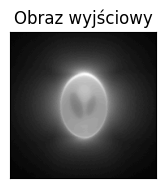

In [28]:
def odwrotna_transformata_radona(sinogram, krok_x):
    x = np.arange(sinogram.shape[0]) - sinogram.shape[0] / 2 # współrzędne X wyśrodkowane względem obrazu
    y = x.copy()
    ox, oy = np.meshgrid(x, y) #siatka współrzędnych (ox, oy)
    num = sinogram.shape[0]
    rekonstrukcja = np.array([[0 for _ in range(num)] for __ in range(num)])  # pusta macierz dla rekonstrukcji obrazu 
    katy = np.arange(0.0, 180, krok_x) * (-1) * math.pi / 180  # tablica kątów w radianach (od 0 do 180 stopni)


    for j in range(len(katy)):
        _projekcja = np.array([[0 for _ in range(num)] for __ in range(num)])
        rotacja = ox * math.sin(katy[j]) - oy * math.cos(katy[j])  # Obliczanie nowych współrzędnych po obrocie
        punkty = np.round(rotacja + num / 2)  # Przesunięcie i zaokrąglenie 
        punkty = punkty.astype('int')  # Konwersja na liczby całkowite 


        p1, p2 = np.where((punkty >= 0) & (punkty < num)) # indeksy pikseli, które mieszczą się w obrazie
        linia = sinogram[:, j] # linia danych dla aktualnego kąta z sinogramu
        _projekcja[p1, p2] = linia[punkty[p1, p2]] # Przypisujemy wartości intensywności do odpowiednich pikseli w _projekcja
        rekonstrukcja += _projekcja 

    rekonstrukcja = rekonstrukcja // len(katy) # Uśredniamy wynik dla wszystkich kątów
    return rekonstrukcja  


rekonstrukcja_obraz = odwrotna_transformata_radona(sinogram_wynik, krok_x) 


sub3 = plt.subplot(133)
sub3.set_title("Obraz wyjściowy")
sub3.set_xticks([], [])
sub3.set_yticks([], [])
sub3.imshow(rekonstrukcja_obraz, cmap='gray')


### **Dwie przykładowe transformacje**

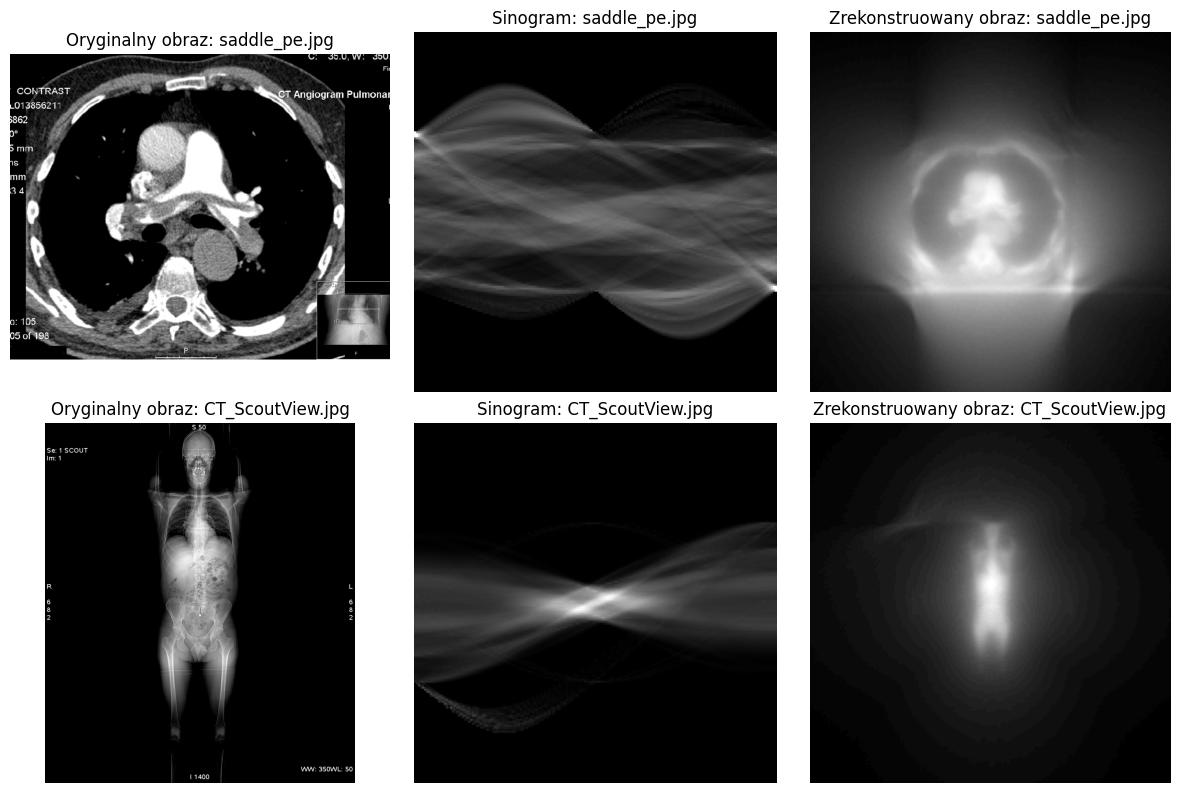

In [26]:
obraz1 = imageio.imread('SADDLE_PE.JPG', mode='F')
obraz2 = imageio.imread('CT_ScoutView.jpg', mode='F')

sinogram1 = transformata_radona(obraz1, krok_a, zakres_pi, liczba_detektorow, krok_x)
sinogram2 = transformata_radona(obraz2, krok_a, zakres_pi, liczba_detektorow, krok_x)

rekonstrukcja1 = odwrotna_transformata_radona(sinogram1, krok_x)
rekonstrukcja2 = odwrotna_transformata_radona(sinogram2, krok_x)

plt.figure(figsize=(12, 8))

# Saddle_PE
plt.subplot(2, 3, 1)
plt.imshow(obraz1, cmap='gray')
plt.title("Oryginalny obraz: saddle_pe.jpg")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(sinogram1, cmap='gray')
plt.title("Sinogram: saddle_pe.jpg")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(rekonstrukcja1, cmap='gray')
plt.title("Zrekonstruowany obraz: saddle_pe.jpg")
plt.axis('off')

# Shepp-Logan
plt.subplot(2, 3, 4)
plt.imshow(obraz2, cmap='gray')
plt.title("Oryginalny obraz: CT_ScoutView.jpg")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(sinogram2, cmap='gray')
plt.title("Sinogram: CT_ScoutView.jpg")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(rekonstrukcja2, cmap='gray')
plt.title("Zrekonstruowany obraz: CT_ScoutView.jpg")
plt.axis('off')

plt.tight_layout()
plt.show()


### **User interface**

In [29]:
import tkinter as tk
from tkinter import filedialog, messagebox
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
import math
import imageio.v2 as imageio
from skimage import color

# Flagi stanu
image_loaded = False  
sinogram_created = False  

# Funkcja do wyboru obrazu
def open_image():
    global image_loaded, sinogram_created
    file_path = filedialog.askopenfilename(title="Wybierz obraz", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg;*.bmp")])
    if file_path:
        global obraz_sciezka, kolorowy_obraz, szaroskalowy_obraz
        obraz_sciezka = file_path
        kolorowy_obraz = imageio.imread(obraz_sciezka)
        szaroskalowy_obraz = color.rgb2gray(kolorowy_obraz)
        show_original_image(szaroskalowy_obraz)
        
        image_loaded = True 
        sinogram_created = False 

# Funkcja do wyświetlania oryginalnego obrazu z lewej strony
def show_original_image(image_data):
    image_pil = Image.fromarray((image_data * 255).astype(np.uint8))  
    image_pil = image_pil.convert("RGB")  
    image_pil = image_pil.resize((250, 250))  
    image_tk = ImageTk.PhotoImage(image_pil)

    original_label.config(image=image_tk)
    original_label.image = image_tk 

    original_label.pack(side="left", padx=10)

# Funkcja do wykonania transformacji Radona i wyświetlenia sinogramu na środku
def radon_transform():
    global sinogram_created
    if not image_loaded:
        messagebox.showwarning("Ostrzeżenie", "Najpierw załaduj obraz!")
        return
    
    if image_loaded and not sinogram_created:
        obraz_ph = imageio.imread(obraz_sciezka, mode='F')
        krok_x = 1.0
        krok_a = krok_x * math.pi / 180
        zakres_pi = math.pi
        liczba_detektorow = 180
        sinogram_wynik = transformata_radona(obraz_ph, krok_a, zakres_pi, liczba_detektorow, krok_x)

        fig, ax = plt.subplots(figsize=(5, 5))
        ax.set_xticks(np.arange(0, 181 / krok_x, 20 / krok_x))
        ax.set_xticklabels([i * 20 for i in range(10)], rotation=45)
        ax.tick_params(axis='x', labelsize=8)
        ax.set_xlabel("Kąt projekcji")
        ax.set_title("Sinogram")
        ax.imshow(sinogram_wynik, cmap='gray')
        
        plt.savefig('sinogram_temp.png', bbox_inches='tight', pad_inches=0)
        plt.close()

        sinogram_img = Image.open('sinogram_temp.png')
        sinogram_img = sinogram_img.convert("RGB")
        sinogram_img = sinogram_img.resize((250, 250)) 
        sinogram_img_tk = ImageTk.PhotoImage(sinogram_img)

        sinogram_label.config(image=sinogram_img_tk)
        sinogram_label.image = sinogram_img_tk

        sinogram_label.pack(side="left", padx=10)
        
        sinogram_created = True  
    else:
        messagebox.showwarning("Ostrzeżenie", "Najpierw stwórz sinogram!")

# Funkcja do wykonania odwrotnej transformacji Radona i wyświetlenia odtworzonego obrazu z prawej strony
def inverse_radon_transform():
    if not sinogram_created:
        messagebox.showwarning("Ostrzeżenie", "Najpierw stwórz sinogram!")
        return

    if image_loaded and sinogram_created:
        obraz_ph = imageio.imread(obraz_sciezka, mode='F')
        krok_x = 1.0
        krok_a = krok_x * math.pi / 180
        zakres_pi = math.pi
        liczba_detektorow = 180
        sinogram_wynik = transformata_radona(obraz_ph, krok_a, zakres_pi, liczba_detektorow, krok_x)

        rekonstrukcja_obraz = odwrotna_transformata_radona(sinogram_wynik, krok_x)

        show_reconstructed_image(rekonstrukcja_obraz)
    else:
        messagebox.showwarning("Ostrzeżenie", "Najpierw załaduj obraz!")

# Funkcja do wyświetlania odtworzonego obrazu z prawej strony
def show_reconstructed_image(image_data):
    image_pil = Image.fromarray((image_data * 255).astype(np.uint8))  
    image_pil = image_pil.convert("RGB")  
    image_pil = image_pil.resize((250, 250)) 
    image_tk = ImageTk.PhotoImage(image_pil)

    reconstructed_label.config(image=image_tk)
    reconstructed_label.image = image_tk  

    reconstructed_label.pack(side="left", padx=10)

# Funkcja do wyczyszczenia wszystkich obrazów
def clear_images():
    global image_loaded, sinogram_created
    
    original_label.config(image='')
    sinogram_label.config(image='')
    reconstructed_label.config(image='')

    image_loaded = False
    sinogram_created = False


# Tworzenie głównego okna interfejsu
root = tk.Tk()
root.title("Transformata Radona")
root.geometry("900x600")

# Tworzenie przycisków
open_button = tk.Button(root, text="Otwórz obraz", command=open_image)
open_button.pack(pady=10)

radon_button = tk.Button(root, text="Transformata Radona", command=radon_transform)
radon_button.pack(pady=10)

inverse_button = tk.Button(root, text="Odwrotna Transformata Radona", command=inverse_radon_transform)
inverse_button.pack(pady=10)

clear_button = tk.Button(root, text="Wyczyść obrazy", command=clear_images)
clear_button.pack(pady=10)

# Tworzenie etykiet do wyświetlania obrazów
original_label = tk.Label(root)
sinogram_label = tk.Label(root)
reconstructed_label = tk.Label(root)

# Uruchamianie interfejsu
root.mainloop()



### **Zapis DICOM**


In [52]:
import numpy as np
import cv2
import pydicom as pd
from pydicom.dataset import FileDataset, FileMetaDataset, validate_file_meta
from pydicom.uid import UID, generate_uid
import ipywidgets as widgets
from IPython.display import display

# Funkcja do zapisania pliku DICOM
def dicom_write(file, data):

    image = cv2.imread(data['image'], cv2.IMREAD_GRAYSCALE)

    file_meta = FileMetaDataset()
    file_meta.MediaStorageSOPClassUID = UID('1.2.840.10008.5.1.4.1.1.2')  
    file_meta.MediaStorageSOPInstanceUID = generate_uid()
    file_meta.ImplementationClassUID = generate_uid()
    file_meta.TransferSyntaxUID = UID('1.2.840.10008.1.2.1')  

    ds = FileDataset(file, {}, file_meta=file_meta, preamble=b'\0'*128)
    ds.PatientName = data['name']
    ds.PatientID = data['id']
    ds.is_little_endian = True
    ds.is_implicit_VR = False
    ds.StudyDate = data['date']

    ds.SeriesInstanceUID = generate_uid()
    ds.StudyInstanceUID = generate_uid()
    ds.FrameOfReferenceUID = generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7

    ds.Rows = image.shape[0]
    ds.Columns = image.shape[1]

    ds.ImagesInAcquisition = '1'
    ds.InstanceNumber = 1
    ds.ImageType = r'ORIGINAL\PRIMARY\AXIAL'

    ds.RescaleIntercept = '0'
    ds.RescaleSlope = '1'
    ds.PixelSpacing = r'1\1'
    ds.PhotometricInterpretation = 'MONOCHROME2'
    ds.PixelRepresentation = 0

    ds.ImageComments = data['comment']
    ds.PixelData = image.tobytes()

    validate_file_meta(ds.file_meta, enforce_standard=True)

    ds.save_as(file, write_like_original=False)


# Funkcja do wprowadzania danych pacjenta
def input_patient_data():
    name_widget = widgets.Text(value='', description='Imię pacjenta:')
    id_widget = widgets.Text(value='', description='ID pacjenta:')
    date_widget = widgets.DatePicker(description='Data badania:')
    image_widget = widgets.Text(value='', description='Ścieżka obrazu:')
    comment_widget = widgets.Text(value='', description='Komentarze:')
    
    def on_button_click(b):
        # Zapisanie danych
        patient_data = {
            'name': name_widget.value,
            'id': id_widget.value,
            'date': date_widget.value.strftime('%Y%m%d') if date_widget.value else '',
            'image': image_widget.value,
            'comment': comment_widget.value,
        }
        # Wywołanie funkcji zapisu DICOM
        dicom_write('file.dcm', patient_data)

    button = widgets.Button(description="Utwórz DICOM")
    button.on_click(on_button_click)

    display(name_widget, id_widget, date_widget, image_widget, comment_widget, button)

# Uruchomienie interfejsu do wprowadzania danych
input_patient_data()




Text(value='', description='Imię pacjenta:')

Text(value='', description='ID pacjenta:')

DatePicker(value=None, description='Data badania:', step=1)

Text(value='', description='Ścieżka obrazu:')

Text(value='', description='Komentarze:')

Button(description='Utwórz DICOM', style=ButtonStyle())

### **Odczyt DICOM**

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 242
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.72685850222954318632285169447946629666
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.31413375906044188102807508242074151294
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.4'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0020) Study Date                          DA: '20050404'
(0010, 0010) Patient's Name                      PN: 'Tsimafei Kotski'
(0010, 0020) Patient ID                          LO: '158740'
(0020, 000d) Study Instance UID          

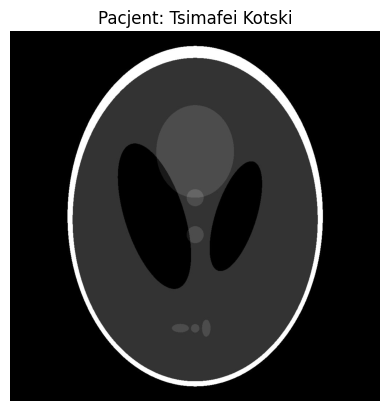

In [53]:
# Funkcja do odczytu pliku DICOM
def dicom_read(file):
    dicom = pd.dcmread(file)
    print(dicom)
    plt.imshow(np.array(dicom.pixel_array).astype(np.uint8), cmap='gray')
    plt.title(f"Pacjent: {dicom.PatientName}")
    plt.axis('off')
    plt.show()
    
dicom_read('file.dcm')